# Scratch Pad: A symbolic playground for Seq2Seq models

```
what does Henry do? <scratch_pad> search('Henry') -> ['Henry is a School Psychologist'] </scratch_pad> School Psychologist

what is 556 - 301? <scratch_pad> 556 - 301 -> 255 </scratch_pad> 255
```

In [2]:
from rank_bm25 import BM25Okapi
from src.models_and_transforms.BERT_models import CausalBERT
from src.models_and_transforms.GPT2_models import GPT2_Actor_Critic_Model
from src.models_and_transforms.text_transforms import Numericalise_Transform, Scratch_Pad_Sequence_Policy_Creator_Transform, \
                                                        Rename_Transform, Class_Rebalance_Transform
from src.pipe_datasets import Scratch_Pad_Policy_Dataset
import re
from transformers import GPT2LMHeadModel, GPT2Config, GPT2Tokenizer, GPT2TokenizerFast, GPT2Model
from transformers import BertConfig, BertTokenizerFast, BertForMaskedLM
from tokenizers import processors, Tokenizer
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning import Trainer, Callback, seed_everything
import numpy as np
import json
from itertools import compress as mask
import sys
import tqdm
from time import perf_counter 
import random
import copy
import matplotlib.pyplot as plt

from src.ScratchPad import ScratchPadGame, EpisodeUtility
from src.FastMCTS import FastMCTS
from dotmap import DotMap
import numpy as np
from time import perf_counter

from src.environments import Scratch_Pad_Environment
from src.FasterMCTS import FasterMCTS
from src.RL_trainer import AlphaZero_Trainer

from src.useful_utils import chunks
from src.models_and_transforms.GPT2_models import GPT2_Scratch_Pad_Model
sys.path.insert(0,"src/external_repos/pyfuzz/")

%load_ext autoreload
%autoreload 2
%load_ext line_profiler
%load_ext memory_profiler

## Searching function

In [2]:
corpus = [
    "Hello there good man!",
    "It is quite windy in London",
    "How is the weather today?"
]
tokenized_corpus = [re.findall(r"[\w']+|[.,!?;]", doc) for doc in corpus]
bm25 = BM25Okapi(tokenized_corpus)

In [3]:
def search(q, n=1):
    return bm25.get_top_n(q.split(), corpus, n=n)

## Trying out tokenizers

In [298]:
from tokenizers import ByteLevelBPETokenizer, Tokenizer
tokenizer = ByteLevelBPETokenizer(add_prefix_space=False)

# And then train
tokenizer.train(
    ["datasets/ScratchPad/samples.txt"],
    vocab_size=1000,
    min_frequency=2,
    show_progress=True,
    special_tokens=['[PAD]','[BOS]','[EOS]','[VALUE]','[MASK]','[NL]','[SP]', '[ESP]','>>>'],
)
tokenizer.enable_padding(direction='left')

tokenizer.save('datasets/ScratchPad/tokenizer_simple.json')
tokenizer = Tokenizer.from_file('datasets/ScratchPad/tokenizer_simple.json')

inputs = tokenizer.encode('[VALUE]What is 8+4?[SP]3+4>>>7[NL][ESP]7[EOS]')
print(inputs.ids)
print(inputs.tokens)
tokenizer.decode(inputs.ids, skip_special_tokens=False)

[3, 269, 268, 270, 19, 28, 39, 6, 27, 19, 28, 8, 31, 5, 7, 31, 2]
['[VALUE]', 'What', 'Ġis', 'Ġ8', '+', '4', '?', '[SP]', '3', '+', '4', '>>>', '7', '[NL]', '[ESP]', '7', '[EOS]']


'[VALUE]What is 8+4?[SP]3+4>>>7[NL][ESP]7[EOS]'

## Using BERT for AlphaZero style learning
The model will be both responsible for state $s$ evaluation into a value $v$ and polilcy $\textbf{p}$

\begin{equation*}
(v,\textbf{p})=f(s|\theta)
\end{equation*}

In [2]:
tokenizer = Tokenizer.from_file('datasets/ScratchPad/tokenizer_simple.json')
env = Scratch_Pad_Environment(tokenizer, device='cpu')

args = {'num_episodes':1000,
        'num_sims_per_turn':2,
        'policy_exploration_weight':0.5}
# trainer = EpisodeUtility(SPGame, **args)


In [3]:
config = BertConfig()
config.num_attention_heads = 8
config.hidden_size = 256
config.num_hidden_layers = 12
config.intermediate_size = 1024
config.n_ctx = 512
config.n_positions = 512
config.is_decoder = True
config.temp = 1
config.vocab_size = len(tokenizer.get_vocab())
config.position_embedding_type = 'relative_key_query'
model = CausalBERT(config, bos_id=tokenizer.token_to_id('[BOS]'), 
                            pad_id=tokenizer.token_to_id('[PAD]'))

In [9]:
_ = model.cuda()
# _ = model.eval()

In [165]:
print(env.strings_to_state(['[BOS]Copy "S9Hi":']))
current_states = env.strings_to_state(['[BOS]Copy "0Kb4nj0MxOXcZX":0Kb4nj0M'])
target_strings = np.array(['What is 3+4?7[EOS]'])
current_states

tensor([[  1,  43,  87,  88,  97, 229,  10,  59,  33,  48,  81,  10,  34]])


tensor([[  1,  43,  87,  88,  97, 229,  10,  24,  51,  74,  28,  86,  82,  24,
          53,  96,  55,  64,  75,  66,  64,  10,  34,  24,  51,  74,  28,  86,
          82,  24,  53]])

In [166]:
pi = model.forward(current_states)[0][0][-1]
env.to_hash(pi.argsort(descending=True)[:10].unsqueeze(1))

['x', 'T', 'r', 'o', 'O', 'j', 'c', '4', 'X', '0']

In [215]:
trainer = AlphaZero_Trainer(model, env)

In [530]:
target_fns[0]('[BOS]What is 133+83?[SP]104+102>>>206[NL][ESP]206[EOS', '[BOS]What is 133+83?206[EOS]')

0

In [526]:
pairs[0]

{'prompt': '[BOS]What is 104+102?',
 'gold': '[BOS]What is 104+102?[SP]104+102>>>206[NL][ESP]206[EOS]',
 'answer': '[BOS]What is 104+102?206[EOS]',
 'match_fn': <function src.environments.Scratch_Pad_Environment.customPromptsAndAnswers.<locals>.match_addition_fn(current_string, answer_string)>}

In [532]:
example_objects = env.customPromptsAndAnswers(prompt_type='simple_addition', n=2)
prompt_strings = [s['prompt'] for s in pairs]
gold_strings = [s['gold'] for s in pairs]
positive_samples = trainer.decomposeSupervisedEpisodes(gold_strings, prompt_strings=prompt_strings)

positive_samples = Class_Rebalance_Transform(field='target_values')(positive_samples)
train_dataset = Scratch_Pad_Policy_Dataset(positive_samples, slow_pipe=[], real_time_pipe=[])
train_dataloader = train_dataset.to_dataloader(16, shuffle=True)

# wandb_logger = WandbLogger(name='GPT2_variable_span_copying_with_solution_1k_supervised',project='ScratchPad')
pl_trainer = Trainer(gpus=1, gradient_clip_val=0.5, amp_level='O1', max_epochs=200)
model.train()
pl_trainer.fit(model, train_dataloader)

No correct seed found, seed set to 2234707284


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


KeyboardInterrupt: 

In [207]:
steps = 100
positive_states, target_strings = env.random_states(10, prompt_type='simple_addition')

for step in range(steps):
    positive_examples = trainer.decomposePositiveEpisodes(positive_states, target_strings)
    exploration_examples = trainer.execute_episodes(episodes=5, simulations=100,seed=10, problem_type='simple_addition')
    
    train_samples = copy.deepcopy(exploration_examples + positive_examples)
    train_samples = Rename_Transform(fields=[('reward', 'target_value'),('current_state', 'input_ids'),('pi','target_policy')])(train_samples)
    train_samples = Class_Rebalance_Transform(field='target_value')(train_samples)
    train_dataset = Scratch_Pad_Policy_Dataset(train_samples, slow_pipe=[], real_time_pipe=[])
    train_dataloader = train_dataset.to_dataloader(3, shuffle=True)
    
    pl_trainer = Trainer(gpus=1, gradient_clip_val=0.5, amp_level='O1', max_epochs=10)
    model.train()
    pl_trainer.fit(model, train_dataloader)

No correct seed found, seed set to 688180719
Sims for 5 episodes:   1%|          | 1/100 [00:00<00:16,  5.87it/s]

For 5 episodes found 5 unique.


Sims for 5 episodes:   0%|          | 0/100 [00:00<?, ?it/s]

0 terminated, 5 left.


Sims for 5 episodes:   0%|          | 0/100 [00:00<?, ?it/s]

0 terminated, 5 left.


Sims for 5 episodes:   0%|          | 0/100 [00:00<?, ?it/s]

0 terminated, 5 left.


Sims for 5 episodes:   0%|          | 0/100 [00:00<?, ?it/s]

0 terminated, 5 left.


Sims for 5 episodes:   0%|          | 0/100 [00:00<?, ?it/s]

0 terminated, 5 left.


Sims for 5 episodes:   0%|          | 0/100 [00:00<?, ?it/s]

0 terminated, 5 left.


Sims for 5 episodes:   7%|▋         | 7/100 [00:04<01:02,  1.49it/s]


KeyboardInterrupt: 

In [1414]:
torch.save(model.state_dict(), 'saved_models/AlphaBERT/model_e50_s1000_add_level_0.ckpt')

In [669]:
_ = model.eval()
current_states = env.strings_to_state(['[BOS]What is 4+5?'])
print(current_states)
example_objects = [{'answer':'[BOS]What is 4+5?9[EOS]', 'match_fn':env.match_no_SP_fn}]
p, v = model.predict(current_states)
env.to_hash(p.argsort(descending=True, dim=1).reshape(-1,1)[:10])

tensor([[  1, 269, 268, 229,  28,  19,  29,  39]])


['[SP]', '0', '8', '4', '5', '3', '6', '[ESP]', '+', 'z']

In [178]:
sorted(list(mcts.cache.items()), key=lambda s: s[1]['N'], reverse=True)[:10]

[('[BOS]What is 5+4?[SP]5',
  {'state': tensor([  1, 269, 268, 229,  29,  19,  28,  39,   6,  29]),
   'N': tensor([18.]),
   'Qa': tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.2286, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000

In [213]:
p = mcts.getActionProb(current_states)
env.to_hash(p.argsort(descending=True).reshape(-1,1)[:10])

['+', '�', '�', '�', '�', '�', '�', '�', '�', '�']

In [1905]:
p = episodes[0]['target_policies'][10]
env.to_hash(p.argsort(descending=True).reshape(-1,1)[:10])

['�', '�', '�', '�', '�', '�', '�', '�', '�', '�']

In [220]:
current_states = env.strings_to_state(['[BOS]What is 5+4?[SP]5'])
target_strings = ['[BOS]What is 5+4?[SP]5+4>>>9\n[ESP]9[EOS]']
episodes = trainer.execute_episodes(simulations=20, force_states=current_states, force_targets=target_strings, seed=None)

No correct seed found, seed set to 3023556307
Sims for 1 episodes:  15%|█▌        | 3/20 [00:00<00:00, 28.97it/s]

For 100 episodes found 1 unique.


Sims for 1 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Top_actions: ['+', '�', '�', '�', '�', '�', '�', '�', '�', '�']
chose: ['+']
0 terminated, 1 left.


Sims for 1 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Top_actions: ['4', '�', '�', '�', '�', '�', '�', '�', '�', '�']
chose: ['4']
0 terminated, 1 left.


Sims for 1 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Top_actions: ['>>>', '5', '�', '�', '�', '�', '�', '�', '�', '�']
chose: ['>>>']
0 terminated, 1 left.


Sims for 1 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Top_actions: ['[ESP]', '�', '�', '�', '�', '�', '�', '�', '�', '�']
chose: ['[ESP]']
0 terminated, 1 left.


Sims for 1 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Top_actions: ['9', '4', '�', '�', '�', '�', '�', '�', '�', '�']
chose: ['9']
0 terminated, 1 left.


Sims for 1 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Top_actions: ['[EOS]', '9', '�', '�', '�', '�', '�', '�', '�', '�']
chose: ['[EOS]']
0 terminated, 1 left.


Sims for 1 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Top_actions: ['[EOS]', '9', '�', '�', '�', '�', '�', '�', '�', '�']
chose: ['[EOS]']
0 terminated, 1 left.


Sims for 1 episodes:   5%|▌         | 1/20 [00:00<00:03,  5.30it/s]

Top_actions: ['[EOS]', '�', '�', '�', '�', '�', '�', '�', '�', '�']
chose: ['[EOS]']
0 terminated, 1 left.


Sims for 1 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Top_actions: ['[EOS]', '�', '�', '�', '�', '�', '�', '�', '�', '�']
chose: ['[EOS]']
0 terminated, 1 left.


Sims for 1 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Top_actions: ['[EOS]', '�', '�', '�', '�', '�', '�', '�', '�', '�']
chose: ['[EOS]']
0 terminated, 1 left.


Sims for 1 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Top_actions: ['[EOS]', '>>>', '9', '�', '�', '�', '�', '�', '�', '�']
chose: ['[EOS]']
0 terminated, 1 left.


Sims for 1 episodes:   5%|▌         | 1/20 [00:00<00:01,  9.78it/s]

Top_actions: ['[EOS]', '>>>', '9', '[SP]', '�', '�', '�', '�', '�', '�']
chose: ['[EOS]']
0 terminated, 1 left.


Sims for 1 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Top_actions: ['[EOS]', '>>>', '[ESP]', '9', '+', '7', '[SP]', ' is', 'D', 'W']
chose: ['[EOS]']
0 terminated, 1 left.


Sims for 1 episodes:   5%|▌         | 1/20 [00:00<00:02,  9.34it/s]

Top_actions: ['[EOS]', '7', '`', 'W', 'D', '�', ' is', '9', '[SP]', '[ESP]']
chose: ['[EOS]']
0 terminated, 1 left.


Sims for 1 episodes:  15%|█▌        | 3/20 [00:00<00:00, 21.01it/s]

Top_actions: ['[EOS]', '8', '7', '\x11', '9', 'W', '~', '`', '+', '�']
chose: ['[EOS]']
0 terminated, 1 left.


Sims for 1 episodes: 100%|██████████| 20/20 [00:01<00:00, 18.75it/s]

Top_actions: ['[EOS]', '�', '8', '\x11', '+', '�', 'W', '�', '�', '7']
chose: ['[EOS]']
1 terminated, 0 left.
Performed 1 episodes in 77.14s.


## Full arithmetic Few-shot learning
We will train the model to learn to copy sequences then give only 10 examples of arithmetic using supervised learning.
I then want to test how well the MCTS approaches new sequences.

In [3]:
tokenizer = Tokenizer.from_file('datasets/ScratchPad/tokenizer_simple.json')
env = Scratch_Pad_Environment(tokenizer, device='cpu')

args = {'num_episodes':1000,
        'num_sims_per_turn':2,
        'policy_exploration_weight':0.5}

In [4]:
config = BertConfig()
config.num_attention_heads = 8
config.hidden_size = 256
config.num_hidden_layers = 12
config.intermediate_size = 1024
config.n_ctx = 512
config.n_positions = 512
config.is_decoder = True
config.temp = 1
config.vocab_size = len(tokenizer.get_vocab())
config.position_embedding_type = 'relative_key_query'
model = CausalBERT(config, pad_id=tokenizer.token_to_id('[PAD]'))
_ = model.to('cuda')

In [5]:
trainer = AlphaZero_Trainer(model, env)

### Supervised training to copy

In [1912]:
example_objects = env.customPromptsAndAnswers(prompt_type='variable_span_copying', n=1000)
prompt_strings = [s['prompt'] for s in example_objects]
gold_strings = [s['gold'] for s in example_objects]
positive_samples = trainer.decomposeSupervisedEpisodes(gold_strings, prompt_strings=prompt_strings)

positive_samples = Class_Rebalance_Transform(field='target_values')(positive_samples)
train_dataset = Scratch_Pad_Policy_Dataset(positive_samples, slow_pipe=[], real_time_pipe=[])
train_dataloader = train_dataset.to_dataloader(16, shuffle=True)

# wandb_logger = WandbLogger(name='GPT2_variable_span_copying_with_solution_1k_supervised',project='ScratchPad')
pl_trainer = Trainer(gpus=1, gradient_clip_val=0.5, amp_level='O1', max_epochs=40)
model.train()
pl_trainer.fit(model, train_dataloader)

No correct seed found, seed set to 3713005873


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type      | Params
------------------------------------------
0 | transformer | BertModel | 10 M  
1 | lm_head     | Linear    | 69 K  
2 | value_head  | Linear    | 256   


1

In [937]:
torch.save(model.state_dict(), 'saved_models/ScratchPad/CBERT_copy_1k.ckpt')

### Testing copying abilities

In [7]:
_ = model.eval()
current_states = env.strings_to_state(['[BOS]Copy "FooB":Fo'])
example_objects = [{'answer':'[BOS]Copy "S9Hi":S9Hi', 'match_fn':env.match_no_SP_fn}]
p, v = model.predict(current_states)
indices = torch.argsort(p, descending=True, dim=1)
print(f"State Value: {float(v):0.2f}")
for idx in indices.reshape(-1,1)[:10]:
    print(f"{env.to_hash(idx.unsqueeze(0))[0]} -> {float(100*p[0,idx]):0.1f}%")

State Value: 0.51
o -> 95.3%
B -> 1.5%
[EOS] -> 0.9%
F -> 0.2%
x -> 0.1%
H -> 0.1%
y -> 0.1%
I -> 0.1%
K -> 0.1%
9 -> 0.1%


## Training the value function through guided exploration

In [6]:
model.load_state_dict(torch.load('saved_models/ScratchPad/CBERT_copy_1k.ckpt'))

<All keys matched successfully>

In [8]:
exploration_copy_objects = env.customPromptsAndAnswers(prompt_type='variable_span_copying', n=10, seed=3)
prompt_states, matched_target_objects = trainer.decomposeGuidedExplorations(exploration_copy_objects)

In [9]:
matched_target_objects[0]

{'prompt': '[BOS]Copy "kI4":',
 'gold': '[BOS]Copy "kI4":kI4[EOS]',
 'answer': '[BOS]Copy "kI4":kI4[EOS]',
 'match_fn': <bound method Scratch_Pad_Environment.match_no_SP_fn of <src.environments.Scratch_Pad_Environment object at 0x7fc6fc1b8ef0>>}

In [10]:
prompt_states.shape

torch.Size([569, 27])

In [2153]:
env.to_hash(prompt_states)

['[BOS]Copy "kI4":',
 '[BOS]Copy "kI4":k',
 '[BOS]Copy "kI4":kI',
 '[BOS]Copy "kI4":kI4',
 '[BOS]Copy "mEAzQO9":',
 '[BOS]Copy "mEAzQO9":m',
 '[BOS]Copy "mEAzQO9":mE',
 '[BOS]Copy "mEAzQO9":mEA',
 '[BOS]Copy "mEAzQO9":mEAz',
 '[BOS]Copy "mEAzQO9":mEAzQ',
 '[BOS]Copy "mEAzQO9":mEAzQO',
 '[BOS]Copy "mEAzQO9":mEAzQO9',
 '[BOS]Copy "hiY1OJ5":',
 '[BOS]Copy "hiY1OJ5":h',
 '[BOS]Copy "hiY1OJ5":hi',
 '[BOS]Copy "hiY1OJ5":hiY',
 '[BOS]Copy "hiY1OJ5":hiY1',
 '[BOS]Copy "hiY1OJ5":hiY1O',
 '[BOS]Copy "hiY1OJ5":hiY1OJ',
 '[BOS]Copy "hiY1OJ5":hiY1OJ5',
 '[BOS]Copy "tpDvkS":',
 '[BOS]Copy "tpDvkS":t',
 '[BOS]Copy "tpDvkS":tp',
 '[BOS]Copy "tpDvkS":tpD',
 '[BOS]Copy "tpDvkS":tpDv',
 '[BOS]Copy "tpDvkS":tpDvk',
 '[BOS]Copy "tpDvkS":tpDvkS',
 '[BOS]Copy "":',
 '[BOS]Copy "ds2s":',
 '[BOS]Copy "ds2s":d',
 '[BOS]Copy "ds2s":ds',
 '[BOS]Copy "ds2s":ds2',
 '[BOS]Copy "ds2s":ds2s',
 '[BOS]Copy "Yxb62G":',
 '[BOS]Copy "Yxb62G":Y',
 '[BOS]Copy "Yxb62G":Yx',
 '[BOS]Copy "Yxb62G":Yxb',
 '[BOS]Copy "Yxb62G":Yxb6

In [11]:
explored_samples = trainer.execute_episodes(simulations=20, force_states=prompt_states, force_targets=matched_target_objects, temp=30, seed=10)

Sims for 569 episodes:   5%|▌         | 1/20 [00:00<00:02,  7.69it/s]

For 100 episodes found 569 unique.


Sims for 569 episodes: 100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


Top_actions: ['k', '�', '�', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['I', '4', '�', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['4', '[EOS]', '�', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['[EOS]', '4', '�', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['m', '�', '�', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['E', 'A', '�', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['A', 'z', '�', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['z', 'Q', '�', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['Q', 'O', '�', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['O', '9', '[EOS]', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['9', '[EOS]', '�', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['[EOS]', '9', 'O', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['h', '�', '�', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['i', 'Y', '�', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['Y', '1', '�', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['1', '

Sims for 556 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Top_actions: ['T', '2', '�', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['2', 'E', 'T', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['E', 'a', '[EOS]', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['a', 'b', '2', 'g', '�', '�', '�', '�', '�', '�']
Top_actions: ['b', 'g', 'E', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['g', 'b', '[EOS]', 'a', '�', '�', '�', '�', '�', '�']
Top_actions: ['[EOS]', 'g', 'b', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['G', '�', '�', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['6', 'X', '�', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['X', 'v', '�', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['v', '[EOS]', '�', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['[EOS]', 'v', '�', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['S', 'T', '�', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['p', 'o', 'x', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['o', 'x', '�', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['x', '

Sims for 556 episodes: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Top_actions: ['I', '4', 'v', 'w', 'b', 'n', 'S', 'T', 'U', 'J']
Top_actions: ['4', 'y', '9', 'H', 'I', 'K', 'w', 'b', 'S', 'T']
Top_actions: ['[EOS]', '4', '6', 'X', 'H', 'y', 'o', 'S', 'U', 'm']
Top_actions: ['[EOS]', 'D', 'i', 'I', 'o', '6', 'b', 'H', 'C', 'y']
Top_actions: ['E', '�', '�', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['A', 'z', '�', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['z', 'Q', '�', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['Q', 'O', 'm', 'z', '�', '�', '�', '�', '�', '�']
Top_actions: ['O', 'Q', '9', '7', '�', '�', '�', '�', '�', '�']
Top_actions: ['9', 'O', 'Q', 'k', 'i', '[EOS]', '�', '�', '�', '�']
Top_actions: ['9', 'O', 'M', '[EOS]', 'w', 'k', 'o', 'D', '�', '�']
Top_actions: ['[EOS]', '9', 'o', 'w', 'i', 'Q', 'z', '7', 'D', '�']
Top_actions: ['i', '�', '�', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['Y', '1', '�', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['1', 'O', 'J', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['O', '

Sims for 555 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Top_actions: ['o', 'L', 'p', '[EOS]', 'b', '�', '�', '�', '�', '�']
Top_actions: ['o', 'j', 'y', '[EOS]', 'p', 'D', 'L', 'z', '�', '�']
Top_actions: ['3', '8', 'k', 't', '0', '4', 'U', 'v', 'i', 'h']
Top_actions: ['[EOS]', '3', 't', '0', 'v', '1', 'c', 'R', 'o', 'M']
Top_actions: ['[EOS]', 'K', 'D', 'p', 'X', 'o', 'R', 'S', 'U', '3']
Top_actions: ['5', 'I', '�', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['I', 'U', '�', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['s', 'U', 'I', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['s', '5', 'l', 'i', 'f', 'U', '�', '�', '�', '�']
Top_actions: ['l', 'i', 'k', 's', 'f', 'B', 'I', 'q', 'p', '9']
Top_actions: ['i', 'l', 'y', 'C', '6', 's', 'H', 'j', '9', '0']
Top_actions: ['i', '[EOS]', 'j', 'v', 'w', 'P', 'y', 'l', 'k', 'u']
Top_actions: ['[EOS]', 'i', 'J', 'l', 'P', 'D', 'o', 'C', 'w', 'a']
Top_actions: ['T', 'M', 'r', 'x', 'I', 'J', '0', 'c', 'm', 'h']
Top_actions: ['[EOS]', 'T', 'Y', 'O', 'v', 'c', 'K', 'x', '6', 'X']
Top_actions:

Sims for 555 episodes: 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]


Top_actions: ['4', 'I', 'S', 'J', 'U', 'T', 'W', 'R', 'K', 'H']
Top_actions: ['[EOS]', '4', 'X', '8', 'b', 'H', 'p', 'o', 'y', 'k']
Top_actions: ['[EOS]', 'S', 'I', 'R', 'K', '4', 'X', '5', 'o', 'w']
Top_actions: ['[EOS]', 'o', '6', 'w', 'K', 'b', 'S', '4', 'H', 'p']
Top_actions: ['A', 'z', '�', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['z', 'E', 'A', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['Q', 'z', 'O', 'm', '�', '�', '�', '�', '�', '�']
Top_actions: ['9', 'Q', 'O', 'L', '[EOS]', '7', '�', '�', '�', '�']
Top_actions: ['9', 'O', 'X', 'o', 'Q', '[EOS]', '�', '�', '�', '�']
Top_actions: ['9', '[EOS]', 'o', 'c', 'O', 'Q', 'w', 'J', 'k', '�']
Top_actions: ['[EOS]', '9', 'Q', 'i', 'e', 'w', 'o', 'k', 'a', '�']
Top_actions: ['[EOS]', 'w', 'O', 'D', 'Q', 'z', 'o', 'K', '9', 'g']
Top_actions: ['Y', 'i', '1', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['1', 'J', 'O', 'Y', '�', '�', '�', '�', '�', '�']
Top_actions: ['O', 'J', '1', '5', 'i', 'h', 'k', '7', 'q', 'U']
Top_acti

Sims for 551 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Top_actions: ['[EOS]', 'N', 'D', 'X', 'w', 'b', 'x', 'p', 'o', 'K']
Top_actions: ['H', 'T', '�', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['T', '2', '�', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['2', 'E', 'T', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['E', 'a', '2', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['a', 'E', 'b', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['b', 'g', 'E', 'a', 'z', 'o', '[EOS]', '�', '�', '�']
Top_actions: ['g', 'b', 'B', 'X', 'Q', 'p', 'I', 'v', 'a', '[EOS]']
Top_actions: ['g', '[EOS]', 'B', 'A', 'D', 'p', 'I', 'Z', 'v', 'b']
Top_actions: ['[EOS]', 'k', 'v', 'y', 'O', 's', 'a', 'p', 'o', 'w']
Top_actions: ['[EOS]', 'w', 'v', 'o', 'y', 'K', '2', 'p', 'a', 'X']
Top_actions: ['X', 'v', 'Y', 'U', '0', 'b', '[EOS]', '�', '�', '�']
Top_actions: ['v', 'X', 'g', 'd', 'U', 'p', 'q', '[EOS]', 'b', '�']
Top_actions: ['v', '[EOS]', 'i', 'x', 'X', 'U', 'z', 'b', 'p', '0']
Top_actions: ['[EOS]', 'U', 'X', 'v', 'N', 'w', 'b', '5', 'p', 'o']


Sims for 551 episodes: 100%|██████████| 20/20 [00:08<00:00,  2.24it/s]


Top_actions: ['[EOS]', '4', 'o', 'w', 'v', 'p', 'i', 'k', 'b', 'X']
Top_actions: ['[EOS]', 'k', 'D', 'o', 'S', 'X', 'R', 'b', '4', 'y']
Top_actions: ['[EOS]', 'o', 'O', 'y', 'K', 'S', 'I', '4', 'p', 'X']
Top_actions: ['[EOS]', 'y', 'p', 'C', 'D', 'I', 'K', '0', 'w', 'a']
Top_actions: ['z', 'Q', 'E', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['Q', 'O', 'z', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['O', 'i', 'Q', '9', '�', '�', '�', '�', '�', '�']
Top_actions: ['9', 'O', 'Q', 'k', '[EOS]', '�', '�', '�', '�', '�']
Top_actions: ['9', '[EOS]', 'Q', 'o', 'O', 'k', '7', 'w', '�', '�']
Top_actions: ['[EOS]', 'O', 'k', 'w', '9', 'o', 'Q', 'i', '7', '�']
Top_actions: ['[EOS]', 'i', 'o', '9', 'w', 'U', 'X', 'a', 'K', 'D']
Top_actions: ['[EOS]', 'o', 'y', 'K', 'i', '5', 'Q', '9', 'D', 'C']
Top_actions: ['1', 'J', 'O', 'Y', '�', '�', '�', '�', '�', '�']
Top_actions: ['O', 'J', '1', 'Y', 'w', 'k', 'q', 'i', '�', '�']
Top_actions: ['J', '5', '7', 'Y', 'O', 'c', 'q', 'T', 'V', 'w']
Top_

Sims for 548 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Top_actions: ['[EOS]', 'W', '0', 'y', 'K', 'b', '3', 'p', 'o', 'w']
Top_actions: ['s', 'I', 'U', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['s', 'l', '5', 'U', 'I', '�', '�', '�', '�', '�']
Top_actions: ['l', 'i', '5', 's', 'f', 'U', 'w', 'm', '[EOS]', '�']
Top_actions: ['i', 'l', 'u', 's', '3', 'G', 'C', 'L', '9', 'B']
Top_actions: ['i', '[EOS]', 'R', 'y', 'l', 'P', '3', 's', 'C', '0']
Top_actions: ['[EOS]', 'i', '6', 'l', 'y', 'P', 'd', 'o', 'w', '0']
Top_actions: ['[EOS]', '5', 'l', 'y', 'z', 'c', 's', '3', 'o', 'w']
Top_actions: ['[EOS]', 'o', 'B', 'H', 'K', 'U', '5', '6', 'P', 'D']
Top_actions: ['[EOS]', 'S', '0', 'M', 'h', 'T', 'K', '5', 'J', 'o']
Top_actions: ['[EOS]', 'm', 'K', 'y', 'c', 'T', 'p', 'o', '6', 'M']
Top_actions: ['[EOS]', '9', 'D', 'o', 'H', 'T', 'z', '5', 'K', 'M']
Top_actions: ['[EOS]', 'p', 'S', 'H', 'M', 't', 'r', 'y', 'a', 'o']
Top_actions: ['[EOS]', 'a', 'r', 'Y', 'y', 'H', 'S', 'p', 'o', '6']
Top_actions: ['[EOS]', 'K', 'o', '6', 'u', 'b', 'r', 'y', 'p

Sims for 548 episodes: 100%|██████████| 20/20 [00:08<00:00,  2.44it/s]


Top_actions: ['[EOS]', 'X', 'K', '4', 'b', 'S', 'U', '6', 'o', 'w']
Top_actions: ['[EOS]', 'O', 'I', 'X', 'U', 'S', 'R', 'z', 'K', 'a']
Top_actions: ['[EOS]', 'M', 'p', 'D', 'y', 'K', 'w', '9', 'S', 'a']
Top_actions: ['[EOS]', 'y', 'p', 'C', 'D', 'I', 'K', '5', 'w', 'a']
Top_actions: ['Q', 'O', 'z', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['O', '9', 'Q', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['9', 'E', 'Q', 'k', 'O', 'w', '[EOS]', '�', '�', '�']
Top_actions: ['9', 'w', 'O', 'o', 'Q', '[EOS]', 'Z', '�', '�', '�']
Top_actions: ['[EOS]', 'i', 'w', 'P', 'K', 'Q', 'k', 'o', '9', 'O']
Top_actions: ['[EOS]', 'C', 'O', 'K', 'w', 'x', 'o', 'D', 'i', '9']
Top_actions: ['[EOS]', 'i', 'K', 'Q', 'o', 'c', 'y', '6', '9', 'C']
Top_actions: ['[EOS]', 'K', '3', 'A', 'c', 'y', 'o', '5', '6', 'S']
Top_actions: ['O', 'J', '1', '5', 'h', '7', 'q', 'k', '�', '�']
Top_actions: ['J', '5', 'O', 'y', 'k', 'i', 'n', '7', '1', 'c']
Top_actions: ['5', 'J', 'y', 'k', 'O', 'b', 'w', 'T', 'V', 'N']


Sims for 545 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Top_actions: ['Q', 'u', 'x', 'M', '[EOS]', '7', 'H', 'm', '�', '�']
Top_actions: ['7', 'u', 'Q', 'H', 'x', 'M', '[EOS]', 'J', 'C', '�']
Top_actions: ['7', 'u', 'Q', '0', 'J', 'x', 'm', 'M', 'i', '[EOS]']
Top_actions: ['7', '[EOS]', 't', 'O', 'a', 'J', 'o', 'm', 'Q', 'u']
Top_actions: ['[EOS]', 'P', 'o', '9', 'C', 'w', 'u', '0', 'Q', 'b']
Top_actions: ['[EOS]', 'i', '9', 'm', 'x', 'K', '7', 'o', 'a', 'u']
Top_actions: ['[EOS]', 'Y', 'u', 'K', 'Q', 'y', 'S', 'r', 'o', 'x']
Top_actions: ['[EOS]', '6', '1', 'K', 'd', 'z', 'p', 'o', 'W', 'y']
Top_actions: ['s', 'V', 'q', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['q', 's', 'j', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['j', 'q', 'L', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['j', 'L', 'o', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['o', 'L', 'j', 'w', '[EOS]', '�', '�', '�', '�', '�']
Top_actions: ['o', 'Z', 'j', '[EOS]', 'y', 'p', '8', 'L', 'N', '�']
Top_actions: ['[EOS]', 'o', 'K', '8', 'Z', 'y', 'p', 'a', 'L', '

Sims for 545 episodes: 100%|██████████| 20/20 [00:07<00:00,  2.68it/s]


Top_actions: ['[EOS]', 'X', '6', 'u', 'y', '4', 'S', 'U', 'p', 'o']
Top_actions: ['[EOS]', 'B', '9', 'S', 'I', '6', 'p', 'o', '0', 'a']
Top_actions: ['[EOS]', 'B', 'y', 'u', 'S', 'K', '5', 'p', 'o', '0']
Top_actions: ['[EOS]', '9', 'C', 'p', 'o', 'X', 'D', 'S', 'k', 'K']
Top_actions: ['O', 'Q', '9', '[EOS]', '�', '�', '�', '�', '�', '�']
Top_actions: ['9', 'O', 'k', 'i', 'Q', '[EOS]', '�', '�', '�', '�']
Top_actions: ['9', '[EOS]', '7', 'k', 'O', 'w', 'x', 'Q', 'i', '�']
Top_actions: ['[EOS]', 'k', 'p', 'O', '9', 'Q', 'S', 'E', 'z', '�']
Top_actions: ['[EOS]', 'P', 'D', '9', 'o', 'K', 'Q', 'w', 'O', 'C']
Top_actions: ['[EOS]', 'i', 'x', 'o', 'K', 'R', 'S', '3', '9', 'P']
Top_actions: ['[EOS]', 'o', '9', 'X', 'y', 'K', 'd', 'U', 'Q', '1']
Top_actions: ['[EOS]', 'a', 'o', '9', 'K', '3', '5', '6', 'p', 'y']
Top_actions: ['J', 'f', '7', 'Y', 'O', 'c', 'T', '5', 'w', 'k']
Top_actions: ['5', 'J', 'Y', 's', 'O', 'c', 'T', 'y', 'K', 'k']
Top_actions: ['5', '[EOS]', 'Y', 'O', 'P', '1', 'p', 'T'

Sims for 543 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Top_actions: ['[EOS]', 'o', '5', 'Y', 'Z', 'K', '2', 'y', 'W', 'H']
Top_actions: ['[EOS]', 'Y', 'o', 'P', 'Q', 'K', 'y', 'X', 'N', '8']
Top_actions: ['[EOS]', 'o', '0', 'w', 'K', '3', 'H', 'p', 'W', 'M']
Top_actions: ['[EOS]', 'i', 'K', 'u', '9', 'C', 'D', '0', 'y', 'a']
Top_actions: ['[EOS]', 'a', 'X', '8', 'K', 'H', '5', 'p', 'o', 'M']
Top_actions: ['l', 'i', 's', 'X', 'U', 'C', '[EOS]', '�', '�', '�']
Top_actions: ['i', 'l', 's', '9', 'P', 'X', 'z', 'B', 'd', '[EOS]']
Top_actions: ['i', 'l', '[EOS]', 'G', 'P', '0', 's', 'y', 'J', 'w']
Top_actions: ['i', '[EOS]', 'l', 's', '3', 'o', '6', 'y', 'D', '9']
Top_actions: ['[EOS]', 'o', 'w', 'v', 'y', 'P', 's', 'H', 'U', '5']
Top_actions: ['[EOS]', 'X', '6', 'K', 's', '5', 'U', 'p', 'o', 'y']
Top_actions: ['[EOS]', 'X', 'o', 'K', '3', '5', 'U', 'p', 'W', 'y']
Top_actions: ['[EOS]', '9', 'i', 'p', 'o', 'd', 'K', 'U', 'P', 'y']
Top_actions: ['[EOS]', 'K', 'r', 'i', 'o', '5', 'X', 'S', 'T', 'D']
Top_actions: ['[EOS]', 'X', 'w', 'K', 'y', 'S', 

Sims for 543 episodes: 100%|██████████| 20/20 [00:07<00:00,  2.70it/s]


Top_actions: ['[EOS]', 'm', 'X', 'u', 'I', 'y', 'S', 'p', 'o', 'w']
Top_actions: ['[EOS]', 'u', 'p', 'D', 'y', 'K', 'w', '9', 'S', 'a']
Top_actions: ['[EOS]', '9', 'D', 'W', 'X', 'o', 'y', 'S', 'z', 'k']
Top_actions: ['[EOS]', 'u', 'C', 'o', 'k', 'a', 'y', 'p', 'K', 'D']
Top_actions: ['9', 'k', 'O', 'Q', 'w', 'L', '[EOS]', '�', '�', '�']
Top_actions: ['9', '[EOS]', 'P', 'k', 'O', 'Q', 'w', 'o', '�', '�']
Top_actions: ['[EOS]', 'o', 'a', 'x', '9', 'O', 'Q', 'D', 'i', 'w']
Top_actions: ['[EOS]', 'Q', '9', 'c', 'i', 'O', 'w', 'o', 'k', 'D']
Top_actions: ['[EOS]', 'K', '9', 'y', 'Q', 'd', 'C', 'D', '1', 'X']
Top_actions: ['[EOS]', 'W', 'D', '9', 'U', 'o', 'z', 'S', 'C', 'K']
Top_actions: ['[EOS]', 'Q', '9', 'K', '5', '6', 'p', 'o', 'w', 'C']
Top_actions: ['[EOS]', '9', 'U', 'p', 'o', 'X', '6', 'd', '5', 'y']
Top_actions: ['5', 'J', 'Y', 's', 'K', 'T', 'I', 'V', 'w', 'O']
Top_actions: ['5', '[EOS]', 'k', 'J', 'O', 'a', 'w', 'y', 'T', 'u']
Top_actions: ['[EOS]', '5', 'P', 'N', 'k', '1', 'T',

Sims for 538 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Top_actions: ['[EOS]', 'K', 'o', 'z', 'Z', 'b', 'p', 'H', 'y', 'X']
Top_actions: ['[EOS]', '8', '9', 'Q', 'K', '5', 'H', 'p', 'o', 'y']
Top_actions: ['[EOS]', 'Y', '8', 'z', 'd', 'K', '5', '6', 'o', 'y']
Top_actions: ['[EOS]', 'K', 'Y', 'w', 'x', 'y', 'U', 'o', '5', 'N']
Top_actions: ['[EOS]', '3', 'i', 'W', 'o', 'H', 'K', 'R', 'p', 'D']
Top_actions: ['[EOS]', 'y', '9', '5', 'b', 'X', 'k', 'p', 'i', 'w']
Top_actions: ['[EOS]', 'f', 'p', 'y', '5', '3', 'b', 'o', 'D', 'C']
Top_actions: ['i', 'l', 's', 'y', '9', 'J', 'w', '5', 'G', '[EOS]']
Top_actions: ['i', '[EOS]', 's', 'N', 'y', '5', 'l', 'P', 'u', 'j']
Top_actions: ['[EOS]', 'i', '5', 'l', 'P', 's', 'J', 'y', '3', 'N']
Top_actions: ['[EOS]', 'i', 'P', '6', 's', '0', 'w', '5', 'l', 'N']
Top_actions: ['[EOS]', '5', 'l', '9', 'P', '3', 'U', 'o', 'y', 'D']
Top_actions: ['[EOS]', '9', 'K', 'p', 'o', '7', 'Y', '5', 'y', 'i']
Top_actions: ['[EOS]', 'Y', 'K', 'W', 'U', 'T', 'S', 'H', 'I', 'z']
Top_actions: ['[EOS]', 'y', 'w', 'o', 'D', 'K', 

Sims for 538 episodes: 100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


Top_actions: ['[EOS]', 'H', 'w', 'p', 'y', 'K', 'C', 'u', 'a', 'o']
Top_actions: ['[EOS]', 'X', 'w', 'K', 'y', 'S', 'p', 'o', 'M', '8']
Top_actions: ['[EOS]', '5', 'o', 'y', 'K', 'b', '3', 'p', 'M', 'k']
Top_actions: ['[EOS]', 'S', 'o', 'y', 'K', 'H', '5', 'p', 'M', 'D']
Top_actions: ['9', '[EOS]', 'i', 'Q', 'o', 'O', 'w', '7', '�', '�']
Top_actions: ['[EOS]', '9', 'Q', 'o', 'w', 'O', 'k', 'T', '�', '�']
Top_actions: ['[EOS]', 'g', 'N', 'U', 'D', 'y', 'K', 'w', '9', 'Q']
Top_actions: ['[EOS]', 'i', 'o', 'O', 'k', 'D', 'P', '9', 'Q', 'S']
Top_actions: ['[EOS]', 'D', '9', 'U', 'o', 'W', 'd', 'Q', 'r', 'C']
Top_actions: ['[EOS]', 'K', 'p', 'C', 'D', 'z', 'y', '9', 'w', 'a']
Top_actions: ['[EOS]', 'o', 'k', 'K', 'z', 'a', 'p', '6', 'y', '9']
Top_actions: ['[EOS]', 'B', '9', '5', 'p', 'o', '6', 'U', 'K', 'y']
Top_actions: ['5', '[EOS]', 'Y', 'O', 'P', 'c', 'p', 'T', 'w', 'V']
Top_actions: ['[EOS]', '5', 'J', 'O', 'K', 'T', 'p', 'a', 'Y', 'd']
Top_actions: ['[EOS]', 's', 'T', 'o', 'y', 'X', 

Sims for 524 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Top_actions: ['[EOS]', '9', 'i', 'o', 'W', '6', 'z', 'K', 'p', 'D']
Top_actions: ['[EOS]', 'X', '6', 'K', 'y', 'd', 'z', 'p', 'U', 'o']
Top_actions: ['[EOS]', 'K', 'i', 'o', 'D', 'y', '9', 'v', 'p', 'a']
Top_actions: ['[EOS]', 'o', '9', 'D', 'p', 'X', 'S', 'H', 'y', 'i']
Top_actions: ['[EOS]', 'p', 'd', '5', 'X', 'H', '9', 'D', 'M', 'C']
Top_actions: ['[EOS]', 'a', 'p', '5', 'o', 'W', 'K', 'y', 'D', 'C']
Top_actions: ['7', '[EOS]', 'O', 'C', 'J', 'u', 'S', 'Q', 'a', 'o']
Top_actions: ['[EOS]', '7', 't', 'J', 'K', 'u', 'S', 'Q', 'a', 'o']
Top_actions: ['[EOS]', 'o', 'Q', 'Y', 'd', 'K', 'x', 'y', 'M', 'l']
Top_actions: ['[EOS]', 'Y', '7', 'P', 'Q', 'c', 'K', 'y', 'o', 'w']
Top_actions: ['[EOS]', 'a', 'Y', '6', 'K', 'Q', 'd', 'y', 'p', 'o']
Top_actions: ['[EOS]', 'S', 'M', 'K', 'y', 'p', 'o', 'Y', 'w', 'a']
Top_actions: ['[EOS]', 'Y', '6', 'y', 'K', 'd', 'S', 'p', 'o', 'H']
Top_actions: ['[EOS]', 'B', '5', 'M', 'y', 'K', 'S', 'p', 'o', 'w']
Top_actions: ['j', 'L', 'D', 'o', 'q', '�', '�',

Sims for 524 episodes: 100%|██████████| 20/20 [00:06<00:00,  3.09it/s]


Top_actions: ['[EOS]', 'o', 'y', 'w', 'v', 'u', 'K', 'd', 'p', 'M']
Top_actions: ['[EOS]', 'b', '9', 'i', '5', 'X', 'S', 'p', 'K', 'D']
Top_actions: ['[EOS]', 'o', '6', 'y', 'u', 'K', 'S', 'H', 'p', 'M']
Top_actions: ['[EOS]', 'y', 'X', 'S', '5', '6', 'p', 'o', 'K', '9']
Top_actions: ['[EOS]', 'K', 'k', 'Q', 'w', '9', 'a', 'o', 'i', 'O']
Top_actions: ['[EOS]', 'K', 'w', '9', 'i', 'k', 'Q', 'o', 'y', 'D']
Top_actions: ['[EOS]', 'w', 'y', 'K', 'C', 'Q', 'U', 'D', 't', '9']
Top_actions: ['[EOS]', 'B', 'i', 'l', 'o', 'X', 'O', 'D', 'k', 'K']
Top_actions: ['[EOS]', 'K', 'D', 'o', 'W', 'Y', '3', '9', 'p', 'y']
Top_actions: ['[EOS]', 'a', '6', 'z', 'K', '5', 'p', 'o', 'y', '9']
Top_actions: ['[EOS]', 'K', 'y', '6', 'a', 'p', 'o', 'k', 'i', '9']
Top_actions: ['[EOS]', '5', 'K', 'v', 'p', 'o', '6', 'U', '9', 'y']
Top_actions: ['[EOS]', '5', '0', 'V', 'z', 'K', 'm', 'X', 'x', '1']
Top_actions: ['[EOS]', '5', 'H', 'K', 'c', 'J', 'T', 'y', 'p', 'o']
Top_actions: ['[EOS]', 'X', 'Y', 'K', 'y', 'd', 

Sims for 509 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

['[EOS]', 'o', '8', 'K', '5', '6', 'p', 'W', 'X', 'y']
Top_actions: ['[EOS]', 'y', 'K', 'p', 'C', 'D', '5', 'S', 'a', 'o']
Top_actions: ['[EOS]', 'R', 'K', 'D', 'o', 'X', 'y', 'J', 'b', 'C']
Top_actions: ['[EOS]', 'o', 'K', '6', 'p', 'X', 'x', 'C', 'D', 'N']
Top_actions: ['[EOS]', 'X', 'a', 'K', 'p', 'D', 'o', 'y', 'i', '1']
Top_actions: ['[EOS]', 'M', 'K', 'X', 'a', 'p', 'o', 'y', 'u', '9']
Top_actions: ['[EOS]', 'y', 'k', 'p', 'C', 'D', 'z', '5', 'K', 'a']
Top_actions: ['[EOS]', 'a', 'y', 'i', '5', 'Y', 'b', 'p', '9', 'M']
Top_actions: ['[EOS]', '5', 'a', 'D', '9', 'C', 'M', 'y', 'K', 'p']
Top_actions: ['[EOS]', 'i', 'a', 'K', 'S', 'y', 'w', 'C', 'p', 'o']
Top_actions: ['[EOS]', 'C', 'K', 'p', 'D', 'y', '6', 'S', 'a', 'X']
Top_actions: ['[EOS]', '5', 'p', 'K', 'w', 'b', 'o', 'y', 'D', 'C']
Top_actions: ['[EOS]', 'u', 'o', 'H', 'a', 'K', 'p', 'y', 'M', '9']
Top_actions: ['[EOS]', 'u', 'J', '7', 'K', '1', 'y', 'o', 'w', '8']
Top_actions: ['[EOS]', 'Y', 'w', 'u', 'K', 'J', 'p', 'W', 'o'

Sims for 509 episodes: 100%|██████████| 20/20 [00:06<00:00,  3.20it/s]


Top_actions: ['[EOS]', 'D', '9', 'o', 'S', 'b', 'k', 'H', 'i', 'w']
Top_actions: ['[EOS]', 'u', 'D', 'p', 'y', 'w', '9', 'K', 'b', 'o']
Top_actions: ['[EOS]', 'K', '5', 'u', 'b', 'S', 'y', 'p', 'o', 'w']
Top_actions: ['[EOS]', '5', 'K', 'C', 'D', 'y', 'p', 'v', 'a', 'o']
Top_actions: ['[EOS]', '9', 'Q', 'o', 'y', 'k', 'i', 'a', 'K', 'u']
Top_actions: ['[EOS]', 'y', 'K', 'P', 'p', 'D', 'w', '9', 'Q', 'b']
Top_actions: ['[EOS]', '9', 'i', 'p', 'o', '6', 'Q', 'd', 'D', 'K']
Top_actions: ['[EOS]', 'B', '6', 'b', '9', 'y', 'Q', 'p', 'D', 'i']
Top_actions: ['[EOS]', 'y', 'p', 'B', 'C', 'D', 'z', '6', 'Q', 'b']
Top_actions: ['[EOS]', 'a', 'K', 'o', 'D', 'z', 'y', '9', 'p', 'U']
Top_actions: ['[EOS]', 'C', 'y', 'K', 'p', 'D', '5', 'M', 'a', 'o']
Top_actions: ['[EOS]', 'a', 'A', 'k', 'K', 'b', 'p', 'o', '6', 'y']
Top_actions: ['[EOS]', 'v', '6', 'O', 'P', 'b', 'L', 'K', '5', 'o']
Top_actions: ['[EOS]', 'o', 'i', 'c', 'Y', 'y', 'D', 'h', '1', 'g']
Top_actions: ['[EOS]', '5', 'X', 'Y', 'y', 'd', 

Sims for 488 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

['[EOS]', 'B', 'P', 'D', 'W', 'U', 'S', 'Y', 'K', 'H']
Top_actions: ['[EOS]', '9', 'K', 'b', '5', '6', 'p', 'o', 'W', 'y']
Top_actions: ['[EOS]', 'k', 'd', 'p', 'o', '6', 'H', 'U', '9', 'y']
Top_actions: ['[EOS]', 'K', '5', '6', 'd', 'p', 'o', 'W', 'y', '9']
Top_actions: ['[EOS]', 'u', 'S', '9', 'W', 'X', 'o', 'H', 'y', 'K']
Top_actions: ['[EOS]', 'K', 'b', '9', 'X', '5', 'S', 'p', 'y', 'u']
Top_actions: ['[EOS]', 'K', 'H', 'p', 'D', 'y', '9', 'M', 'a', 'o']
Top_actions: ['[EOS]', 'o', 'y', 'K', 'S', 'H', 'r', '5', 'p', 'M']
Top_actions: ['[EOS]', 'p', 'a', 'K', 'C', 'r', 'y', 'o', 'H', 'D']
Top_actions: ['[EOS]', 'h', '6', 'K', 'u', 'a', 'p', 'o', '5', 'y']
Top_actions: ['[EOS]', 'w', 'D', 'o', 'p', 'y', '9', 'K', 'a', 'W']
Top_actions: ['[EOS]', '5', '9', '6', 'K', 'a', 'y', 'p', 'o', 'M']
Top_actions: ['[EOS]', 'C', 'K', 'Q', 'p', 'X', 'Y', 'y', 'D', '9']
Top_actions: ['[EOS]', 'o', 'Q', 'D', 'X', 'd', 'R', 'y', 'k', '9']
Top_actions: ['[EOS]', 'K', 'p', 'o', 'D', 'a', 'y', 'k', 'X'

Sims for 488 episodes:   0%|          | 0/20 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 116.00 MiB (GPU 0; 10.76 GiB total capacity; 9.15 GiB already allocated; 53.44 MiB free; 732.21 MiB cached)

In [2221]:
[(s['state_string'], s['target_values'][-1]) for s in explored_samples]

[('[BOS]Copy "kI4":kI4', tensor(1.)),
 ('[BOS]Copy "mEAzQO9":mEAzQO9', tensor(1.)),
 ('[BOS]Copy "hiY1OJ5":hiY1OJ5', tensor(1.)),
 ('[BOS]Copy "tpDvkS":tpDvkS', tensor(1.)),
 ('[BOS]Copy "ds2s":ds2s', tensor(1.)),
 ('[BOS]Copy "Yxb62G":Yxb62G', tensor(1.)),
 ('[BOS]Copy "w1azjh":w1azjh', tensor(1.)),
 ('[BOS]Copy "k4q519":k4q519', tensor(1.)),
 ('[BOS]Copy "4jsNzjRD":4jsNzjRD', tensor(1.)),
 ('[BOS]Copy "FxZJSv2":FxZJSv2', tensor(1.)),
 ('[BOS]Copy "mCsU28f9T":mCsU28f9T', tensor(1.)),
 ('[BOS]Copy "BMZlJC1T":BMZlJC1T', tensor(1.)),
 ('[BOS]Copy "3X":3X', tensor(1.)),
 ('[BOS]Copy "1X1qG8y":1X1qG8y', tensor(1.)),
 ('[BOS]Copy "asOS":asOS', tensor(1.)),
 ('[BOS]Copy "giAZ":giAZ', tensor(1.)),
 ('[BOS]Copy "TXkInUV4l":TXkInUV4l', tensor(1.)),
 ('[BOS]Copy "tBDp":tBDp', tensor(1.)),
 ('[BOS]Copy "PckTW":PckTW', tensor(1.)),
 ('[BOS]Copy "v0QwG":v0QwG', tensor(1.)),
 ('[BOS]Copy "qIfoQUqoG":qIfoQUqoG', tensor(1.)),
 ('[BOS]Copy "TUzb1KUo2":TUzb1KUo2', tensor(1.)),
 ('[BOS]Copy "QwC7Tzj":QwC

In [12]:
for ex in explored_samples:
    ex['target_policies'] = torch.zeros_like(ex['target_policies'])

NameError: name 'explored_samples' is not defined

In [2168]:
train_exp_dataset[-1]

{'positive_string': '[BOS]Copy "J":J[EOS]',
 'input_ids': tensor([  1,  43,  87,  88,  97, 229,  10,  50,  10,  34,  50]),
 'target_policies': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.]]),
 'target_values': tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'not_auto_gen_mask': tensor([False, False, False, False, False, False, False, False, False,  True,
          True])}

In [2229]:
# explored_samples = Class_Rebalance_Transform(field='target_values')(explored_samples)
example_objects = env.customPromptsAndAnswers(prompt_type='variable_span_copying', n=20)
prompt_strings = [s['prompt'] for s in example_objects]
gold_strings = [s['gold'] for s in example_objects]
positive_samples = trainer.decomposeSupervisedEpisodes(gold_strings, prompt_strings=prompt_strings, v=0)

train_exp_dataset = Scratch_Pad_Policy_Dataset(explored_samples + positive_samples, slow_pipe=[], real_time_pipe=[])
train_exp_dataloader = train_exp_dataset.to_dataloader(4, shuffle=True)

model.lr=0.00002
# wandb_logger = WandbLogger(name='GPT2_variable_span_copying_with_solution_1k_supervised',project='ScratchPad')
pl_trainer = Trainer(gpus=1, gradient_clip_val=0.5, amp_level='O1', max_epochs=40)
model.train()
pl_trainer.fit(model, train_exp_dataloader)

No correct seed found, seed set to 2612294957


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type      | Params
------------------------------------------
0 | transformer | BertModel | 10 M  
1 | lm_head     | Linear    | 69 K  
2 | value_head  | Linear    | 256   


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 10.76 GiB total capacity; 9.29 GiB already allocated; 3.44 MiB free; 634.82 MiB cached)

In [2206]:
_ = model.eval()
current_states = env.strings_to_state(['[BOS]Copy "TTrsdf5453tgsff":T'])
example_objects = [{'answer':'[BOS]Copy "S9Hi":S9Hi', 'match_fn':env.match_no_SP_fn}]
p, v = model.predict(current_states)
indices = torch.argsort(p, descending=True, dim=1)
print(f"State Value: {float(v):0.2f}")
for idx in indices.reshape(-1,1)[:10]:
    print(f"{env.to_hash(idx.unsqueeze(0))[0]} -> {float(100*p[0,idx]):0.1f}%")

State Value: -0.98
[EOS] -> 29.7%
O -> 9.8%
k -> 5.3%
J -> 4.6%
2 -> 3.8%
1 -> 3.6%
8 -> 3.5%
d -> 2.9%
c -> 2.4%
C -> 2.2%


### Fine-tuning on 10 samples of arithmetic and some copying also
I think the amount I will use is 10 of arithmetic and 30 of copying

In [1996]:
model.load_state_dict(torch.load('saved_models/ScratchPad/CBERT_copy_1k.ckpt'))

<All keys matched successfully>

In [8]:
copy_objects = env.customPromptsAndAnswers(prompt_type='variable_span_copying', n=30)
arithmetic_objects = env.customPromptsAndAnswers(prompt_type='simple_addition_5_digit', n=50)
all_objects = copy_objects + arithmetic_objects

prompt_strings = [s['prompt'] for s in all_objects]
gold_strings = [s['gold'] for s in all_objects]
positive_samples = trainer.decomposeSupervisedEpisodes(gold_strings, prompt_strings=prompt_strings, v=1)

positive_samples = Class_Rebalance_Transform(field='target_values')(positive_samples)
train_dataset = Scratch_Pad_Policy_Dataset(positive_samples, slow_pipe=[], real_time_pipe=[])
train_dataloader = train_dataset.to_dataloader(4, shuffle=True)

model.lr=0.00002
# wandb_logger = WandbLogger(name='GPT2_variable_span_copying_with_solution_1k_supervised',project='ScratchPad')
pl_trainer = Trainer(gpus=1, gradient_clip_val=0.5, amp_level='O1', max_epochs=40)
model.train()
pl_trainer.fit(model, train_dataloader)

No correct seed found, seed set to 885723966
No correct seed found, seed set to 3511590402


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name        | Type      | Params
------------------------------------------
0 | transformer | BertModel | 10 M  
1 | lm_head     | Linear    | 69 K  
2 | value_head  | Linear    | 256   
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.

# log on a step or aggregate epoch metric to the logger and/or progress bar
# (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

In [9]:
[s['gold'] for s in arithmetic_objects]

['[BOS]What is 1144+4576?[SP]1144+4576>>>5720[NL][ESP]5720[EOS]',
 '[BOS]What is 9651+2676?[SP]9651+2676>>>12327[NL][ESP]12327[EOS]',
 '[BOS]What is 1566+1149?[SP]1566+1149>>>2715[NL][ESP]2715[EOS]',
 '[BOS]What is 9514+8336?[SP]9514+8336>>>17850[NL][ESP]17850[EOS]',
 '[BOS]What is 3209+9468?[SP]3209+9468>>>12677[NL][ESP]12677[EOS]',
 '[BOS]What is 9480+7552?[SP]9480+7552>>>17032[NL][ESP]17032[EOS]',
 '[BOS]What is 9595+9626?[SP]9595+9626>>>19221[NL][ESP]19221[EOS]',
 '[BOS]What is 97+9249?[SP]97+9249>>>9346[NL][ESP]9346[EOS]',
 '[BOS]What is 5096+6785?[SP]5096+6785>>>11881[NL][ESP]11881[EOS]',
 '[BOS]What is 6158+1302?[SP]6158+1302>>>7460[NL][ESP]7460[EOS]',
 '[BOS]What is 428+6445?[SP]428+6445>>>6873[NL][ESP]6873[EOS]',
 '[BOS]What is 2751+3376?[SP]2751+3376>>>6127[NL][ESP]6127[EOS]',
 '[BOS]What is 5374+4224?[SP]5374+4224>>>9598[NL][ESP]9598[EOS]',
 '[BOS]What is 9624+459?[SP]9624+459>>>10083[NL][ESP]10083[EOS]',
 '[BOS]What is 200+6364?[SP]200+6364>>>6564[NL][ESP]6564[EOS]',
 '[BOS

In [33]:
_ = model.eval()
current_states = env.strings_to_state(['[BOS]What is 2180436+6?[SP]2180436+6'])
example_objects = [{'answer':'[BOS]What is 4+3?7[EOS]', 'match_fn':env.match_no_SP_fn}]
p, v = model.predict(current_states)
indices = torch.argsort(p, descending=True, dim=1)
print(f"State Value: {float(v):0.2f}")
for idx in indices.reshape(-1,1)[:10]:
    print(f"{env.to_hash(idx.unsqueeze(0))[0]} -> {float(100*p[0,idx]):0.1f}%")

State Value: 0.98
>>> -> 98.6%
6 -> 0.4%
4 -> 0.1%
[ESP] -> 0.1%
+ -> 0.1%
[SP] -> 0.0%
[EOS] -> 0.0%
1 -> 0.0%
8 -> 0.0%
� -> 0.0%


In [1811]:
exploration_arithmetic_objects = env.customPromptsAndAnswers(prompt_type='simple_addition', n=5, seed=6)
prompt_states, matched_target_objects = trainer.decomposeGuidedExplorations(exploration_arithmetic_objects)

In [1897]:
mcts = FasterMCTS(model, env)

In [1903]:
mcts.search(current_states, example_objects)

tensor([0.9458])

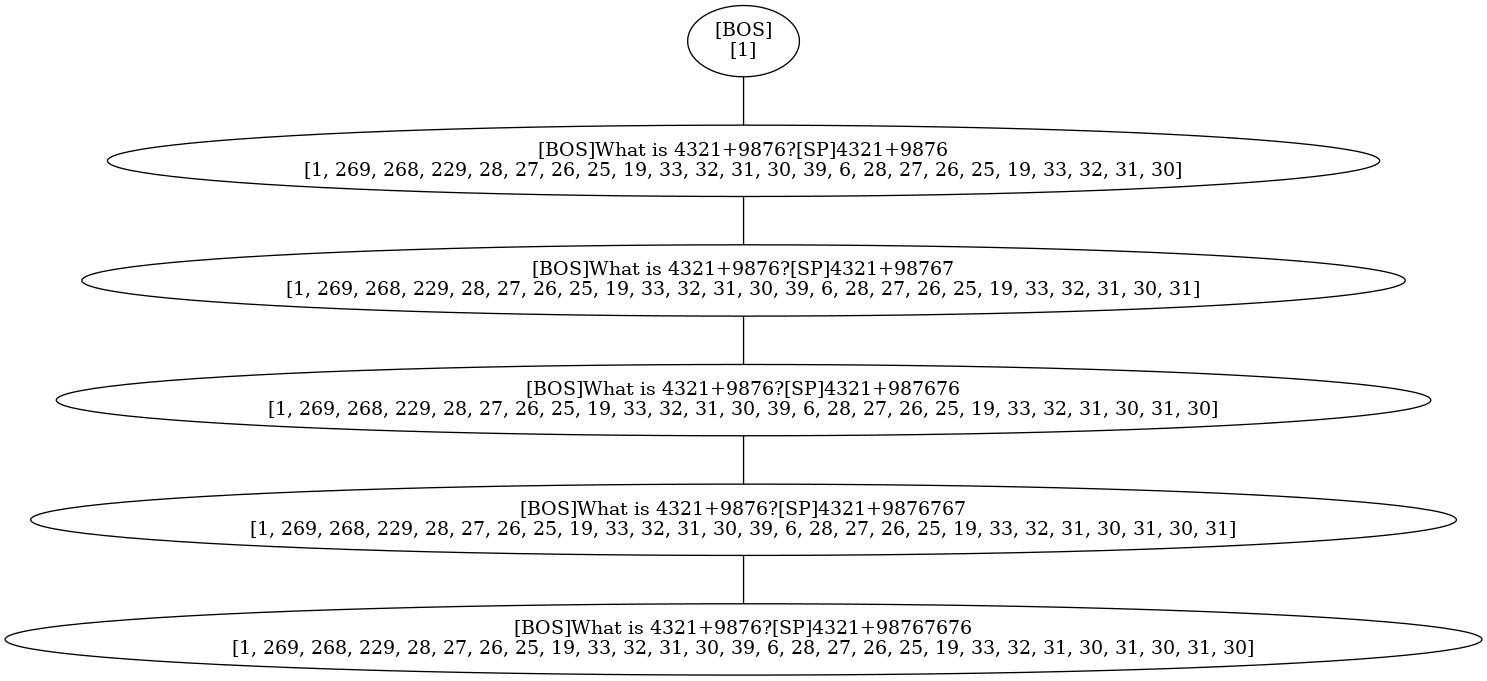

In [1904]:
mcts.plot()

In [1842]:
mcts.print_stats(prompt_states)

[BOS]What is 25+18?  N:26; [SP]->92.0% +->8.0% �->0.0% ; (pV/avgV): -0.14/-0.07; Pred Tokens: [SP]->85.3% +->4.3% 2->0.4% 
[BOS]What is 25+18?[SP]  N:49; 2->95.8% 1->4.2% �->0.0% ; (pV/avgV): -0.10/0.03; Pred Tokens: 2->96.3% 1->1.3% +->0.2% 
[BOS]What is 25+18?[SP]2  N:72; 5->54.9% +->18.3% 4->4.2% ; (pV/avgV): -0.09/-0.01; Pred Tokens: 5->63.4% +->14.6% 0->2.5% 
[BOS]What is 25+18?[SP]25  N:65; >>>->26.6% [SP]->20.3% +->18.8% ; (pV/avgV): -0.13/-0.07; Pred Tokens: +->57.5% >>>->26.6% [SP]->1.9% 
[BOS]What is 25+18?[SP]25+  N:38; 1->35.1% 0->13.5% 5->8.1% ; (pV/avgV): -0.31/-0.02; Pred Tokens: 1->90.1% 5->3.5% 0->2.3% 
[BOS]What is 25+18?[SP]25+1  N:39; 5->60.5% >>>->21.1% 8->7.9% ; (pV/avgV): -0.26/0.00; Pred Tokens: 5->80.0% >>>->7.6% 4->1.6% 
[BOS]What is 25+18?[SP]25+18  N:29; >>>->100.0% �->0.0% �->0.0% ; (pV/avgV): 0.76/-0.06; Pred Tokens: >>>->69.6% +->9.8% 5->7.4% 
[BOS]What is 25+18?[SP]25+18>>>43[NL]  N:54; [ESP]->100.0% �->0.0% �->0.0% ; (pV/avgV): 0.83/-0.18; Pred Tokens: 

In [1731]:
node = mcts.cache['[BOS]What is 295+60?[SP]295+60>>>355[NL][ESP]355']
N = node['N']
print(N)
Nas = node['Na']
indices = torch.argsort(Nas, descending=True)
for idx in indices.reshape(-1,1)[:10]:
    print(f"{env.to_hash(idx.unsqueeze(0))[0]} -> {float(100*Nas[idx]):0.1f}%")

tensor([3146.])
[EOS] -> 313600.0%
3 -> 900.0%
� -> 0.0%
� -> 0.0%
� -> 0.0%
� -> 0.0%
� -> 0.0%
� -> 0.0%
� -> 0.0%
� -> 0.0%


In [1653]:
_ = model.to('cuda')

In [1725]:
current_states = env.strings_to_state(['[BOS]What is 295+60?[SP]',
                                       '[BOS]What is 295+60?[SP]2',
                                       '[BOS]What is 295+60?[SP]29',
                                       '[BOS]What is 295+60?[SP]295',
                                       '[BOS]What is 295+60?[SP]295+',
                                      '[BOS]What is 295+60?[SP]295+6',
                                      '[BOS]What is 295+60?[SP]295+60',
                                      '[BOS]What is 295+60?[SP]295+60>>>355[NL]',
                                      '[BOS]What is 295+60?[SP]295+60>>>355[NL][ESP]',
                                      '[BOS]What is 295+60?[SP]295+60>>>355[NL][ESP]3',
                                      '[BOS]What is 295+60?[SP]295+60>>>355[NL][ESP]35',
                                      '[BOS]What is 295+60?[SP]295+60>>>355[NL][ESP]355'])
example_objects = [{'answer':'[BOS]What is 295+60?355[EOS]', 'match_fn':env.match_no_SP_fn}]*12
for i in tqdm.tqdm(range(200)):
    mcts.search(current_states, example_objects)
mcts.plot()

100%|██████████| 200/200 [00:23<00:00,  8.37it/s]


"dot" with args ['-Tpng', '/tmp/tmpruchn0yu'] returned code: 1

stdout, stderr:
 b''
b"Error: /tmp/tmpruchn0yu: syntax error in line 1018 near ']'\n"



AssertionError: 1

In [1317]:
prompt_strings = ['[BOS]What is 4+5?[SP]', 
                  '[BOS]What is 4+5?[SP]4', 
                  '[BOS]What is 4+5?[SP]4+', 
                  '[BOS]What is 4+5?[SP]4+5', 
                  '[BOS]What is 4+5?[SP]4+5>>>9[NL]', 
                  '[BOS]What is 4+5?[SP]4+5>>>9[NL][ESP]',
                  '[BOS]What is 4+5?[SP]4+5>>>9[NL][ESP]9']
prompt_states = env.strings_to_state(prompt_strings)
target_objects = [{'answer':'[BOS]What is 4+6?10[EOS]', 'match_fn':env.match_no_SP_fn}]*7

explored_samples = trainer.execute_episodes(simulations=40, force_states=prompt_states, force_targets=target_objects, seed=10)

Sims for 7 episodes:   0%|          | 0/40 [00:00<?, ?it/s]

For 100 episodes found 7 unique.


Sims for 7 episodes:   2%|▎         | 1/40 [00:00<00:05,  7.61it/s]

Top_actions: ['4', 'V', '�', 'D', '3', '5', '6', '8', 'W', '\x19']
Top_actions: ['+', '[ESP]', '[SP]', '\x03', '�', '>>>', '\x1c', '�', '�', '�']
Top_actions: ['5', 'm', 'E', '>>>', '6', 'a', '0', '�', 'V', '3']
Top_actions: ['>>>', '�', '�', '�', '5', '>', '\x13', '�', '�', '4']
Top_actions: ['[ESP]', '�', '�', '�', '�', '\x1d', '�', '\x13', '�', '�']
Top_actions: ['5', '�', 'b', 'I', '�', 'F', 'L', 'E', '�', '9']
Top_actions: ['[ESP]', '[EOS]', '5', '9', '{', '�', '�', '�', '�', 'x']
chose: ['4', '+', '5', '�', '�', '5', '�']
0 terminated, 7 left.


Sims for 6 episodes:   2%|▎         | 1/40 [00:00<00:05,  7.63it/s]

Top_actions: ['+', '>>>', '[SP]', '�', '[ESP]', '\x03', '\x1c', '\x13', '\x11', '�']
Top_actions: ['5', 'm', '6', '�', '>>>', 'E', 'r', 'W', 'a', '`']
Top_actions: ['>>>', '�', '�', '�', '�', '�', '�', '\x03', '\x01', 'j']
Top_actions: ['5', '>>>', '�', '�', '�', '!', '+', '�', 'l', 'u']
Top_actions: ['\x11', '^', '{', 'x', 't', '\x03', '\t', '\n', '\r', '�']
Top_actions: ['[EOS]', '\n', ']', 'n', 'i', '\t', 'f', 't', 'b', 'x']
Top_actions: ['P', '�', '|', '�', '�', '�', '\x1a', '\x11', '\x1c', ']']
chose: ['+', '5', '�', '�', '�', '[EOS]', 'Wh']
1 terminated, 6 left.


Sims for 6 episodes:   2%|▎         | 1/40 [00:00<00:06,  6.35it/s]

Top_actions: ['5', 'm', '>>>', '6', '�', 'r', 'E', '\x1a', '{', '\x1b']
Top_actions: ['>>>', '�', '"', '�', '\x00', '�', '�', '�', '�', '�']
Top_actions: ['5', '>>>', '�', '�', '�', '+', 'B', '�', '!', '�']
Top_actions: ['[EOS]', 'j', '�', 'U', '+', '5', '�', 'k', 'n', '�']
Top_actions: ['Q', '�', '\x18', 'X', '\x19', '�', '�', 'T', '\x1d', '\\']
Top_actions: ['�', '\x10', 't', 'u', '�', '�', 'x', '5', '�', 'a']
chose: ['5', '�', '5', '\t', '�', '�']
0 terminated, 6 left.


Sims for 6 episodes:   0%|          | 0/40 [00:00<?, ?it/s]

Top_actions: [':', '>>>', '�', '"', '\x00', '�', '�', '�', '�', '�']
Top_actions: ['5', '>>>', 'B', '�', '�', '!', '+', '"', '@', '�']
Top_actions: ['5', '�', '�', '�', 'N', 'L', '�', '\x17', 'H', '�']
Top_actions: ['�', 'U', '�', '|', ';', '�', '\r', '�', '5', '\x13']
Top_actions: ['[', 'X', 't', '\t', 'l', 'i', ' 8', ']', '\x18', 'x']
Top_actions: ['�', '�', 'T', '�', '�', '�', '�', 'L', '�', ']']
chose: [':', '5', '�', '�', '�', '�']
0 terminated, 6 left.


Sims for 6 episodes:   0%|          | 0/40 [00:00<?, ?it/s]

Top_actions: ['4', 'D', '�', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['5', '�', '�', '\x17', '\x18', '�', '�', '\x1b', '\x1c', '�']
Top_actions: ['5', '�', 't', '\x05', '\t', '\x07', 'l', 'u', 'x', '\x03']
Top_actions: ['�', 'L', '\\', '�', '\x1b', 'U', 'S', 'R', 'Q', '�']
Top_actions: ['�', '�', ']', 'l', 'z', '�', '5', '9', '�', '�']
Top_actions: ['\x07', '\x05', 'l', '\t', 'o', '\r', '\x0e', 's', 't', 'u']
chose: ['4', '�', '#', '�', '0', 'r']
0 terminated, 6 left.


Sims for 6 episodes:   5%|▌         | 2/40 [00:00<00:03, 10.62it/s]

Top_actions: ['4', '�', '�', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['5', '�', '�', '�', '�', '\x05', '�', '�', '\x07', '\x03']
Top_actions: ['5', '�', 'S', '\x18', '\x1b', '�', 'z', '�', 'G', 'F']
Top_actions: ['�', '�', '�', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['�', '�', 'G', '�', '�', '�', '�', '{', '\t', '>']
Top_actions: [':', '�', '�', '\x1b', '�', 'L', '{', '@', '�', '�']
chose: ['4', '{', ']', '\x1a', '�', ':']
0 terminated, 6 left.


Sims for 6 episodes:   0%|          | 0/40 [00:00<?, ?it/s]

Top_actions: ['5', 'T', '0', 'H', 'b', 'e', '�', '�', '�', '�']
Top_actions: ['�', '\x10', '�', '�', '\x11', '{', '�', '5', '\\', '�']
Top_actions: ['K', 'E', '�', '�', 'N', 'M', '\x18', 'F', '{', '�']
Top_actions: ['S', '�', '{', '4', '5', '\x17', '\x18', 'U', '�', '�']
Top_actions: ['L', '�', '�', 'U', 'T', 'S', 'R', 'Q', 'N', '\\']
Top_actions: ['4', 'D', 'K', 'R', 'Q', '0', 'v', 'M', 'B', '7']
chose: ['5', '�', '�', '�', '�', '�']
0 terminated, 6 left.


Sims for 5 episodes:   2%|▎         | 1/40 [00:00<00:07,  5.45it/s]

Top_actions: ['5', '�', '�', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['�', '\x03', 't', 'j', 'l', 'o', '\r', 's', '\x10', 'u']
Top_actions: ['F', '�', '�', 'N', '�', '�', 'I', 'S', 'E', '\x18']
Top_actions: ['�', '�', '�', 'S', 'R', 'Q', '\x1b', '�', '\x18', '�']
Top_actions: ['�', '�', '[', '�', '\x18', '�', 'T', '�', '�', '\x11']
Top_actions: ['4', 'J', 'R', 'Q', 'M', 'L', 'V', 'K', 'H', 'A']
chose: ['5', '�', ':', 'p', '�', '\x06']
1 terminated, 5 left.


Sims for 5 episodes:   2%|▎         | 1/40 [00:00<00:07,  5.20it/s]

Top_actions: ['5', '4', 'e', '8', '0', 'S', 'T', 'v', 'd', 'm']
Top_actions: ['�', 'F', 'S', 'Q', '\x1b', 'N', '�', 'K', 'U', '\x18']
Top_actions: ['4', 'D', 'Q', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['F', '�', '�', 'K', '�', 'I', 'Q', '�', 'S', '�']
Top_actions: ['"', ']', 'b', '�', '\\', '�', 'a', 'U', '\x18', '�']
chose: ['5', '�', '4', '�', '�']
0 terminated, 5 left.


Sims for 4 episodes:   2%|▎         | 1/40 [00:00<00:05,  6.74it/s]

Top_actions: ['4', '8', 'm', 'T', '�', '�', '�', '�', '�', '�']
Top_actions: ['�', '\x13', '�', '�', '�', '�', 'T', 'W', '5', '�']
Top_actions: ['4', '�', '�', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['\x18', '�', '�', 'U', 'T', 'S', 'R', 'Q', '\x13', '�']
Top_actions: ['K', 'I', 'T', '�', 'Q', '�', 'N', '�', '�', '\x13']
chose: ['4', '�', '4', '�', '\x15']
1 terminated, 4 left.


Sims for 4 episodes:   2%|▎         | 1/40 [00:00<00:05,  6.66it/s]

Top_actions: ['4', '5', 'v', 'e', '0', 'H', 'J', 'I', 'L', '�']
Top_actions: ['_', '\x18', 'Z', '\x1b', '\\', 'W', '�', 'a', 'b', '�']
Top_actions: ['5', 'T', 'H', '7', '9', 'B', 'G', 'u', '0', 'e']
Top_actions: ['K', '�', 'S', 'R', '\x18', '�', '�', 'U', 'W', '�']
chose: ['4', ' 8', 'T', '\x05']
0 terminated, 4 left.


Sims for 4 episodes:   2%|▎         | 1/40 [00:00<00:04,  9.15it/s]

Top_actions: ['4', '5', '\x16', 'H', 'S', '\x1e', 'Z', 'Y', 'X', 'V']
Top_actions: ['�', '�', 'L', '�', 'H', 'G', '\x18', '�', '{', '�']
Top_actions: ['5', 'H', 'N', '0', 'l', 'e', 'd', '4', '�', '�']
Top_actions: ['�', '\x18', 'U', 'T', 'S', '5', 'Q', '�', '�', '�']
chose: ['4', '�', '5', '�']
0 terminated, 4 left.


Sims for 3 episodes:   5%|▌         | 2/40 [00:00<00:02, 12.82it/s]

Top_actions: ['5', 'P', '\t', 'Y', '0', '1', 'x', 'z', '�', 'T']
Top_actions: ['�', '�', '\x1b', 'W', 'U', 'T', 'S', 'R', 'Q', '\\']
Top_actions: ['5', 'L', 'M', 'J', 'y', '+', '6', 'v', 'm', '0']
Top_actions: ['R', '\x1a', '�', '\x18', '�', 'U', 'T', 'S', '\x13', 'Q']
chose: ['5', '\x15', '5', '�']
1 terminated, 3 left.


Sims for 2 episodes:   5%|▌         | 2/40 [00:00<00:03, 12.54it/s]

Top_actions: ['5', 'd', '�', 'a', 'b', 'c', 'D', 'e', '9', '\x07']
Top_actions: ['S', '�', '{', '5', '�', '�', '�', '�', 'T', '�']
Top_actions: ['4', 'M', 'J', 'V', 'T', 'S', 'R', '�', '�', 'L']
chose: ['5', '�', '4']
1 terminated, 2 left.


Sims for 2 episodes: 100%|██████████| 40/40 [00:02<00:00, 13.39it/s]

Top_actions: ['[EOS]', '5', 'e', '9', 'c', '�', 'd', 'a', '�', 'P']
Top_actions: ['R', 'Q', '\x13', '�', 'W', 'U', 'T', '\x18', '�', 'a']
chose: ['[EOS]', '0']
2 terminated, 0 left.
Performed 7 episodes in 106.37s.


In [1289]:
env.to_hash(explored_samples[4]['input_ids'][explored_samples[4]['not_auto_gen_mask']].unsqueeze(0))

['+4040400404040']

In [1274]:
explored_samples[4]

{'state_string': '[BOS]What is 4+6?[SP]4+4+4>>>12[NL]11111R',
 'input_ids': tensor([  1, 269, 268, 229,  28,  19,  30,  39,   6,  28,  19,  28,  19,  28,
           8,  25,  26,   5,  25,  25,  25,  25,  25,  58]),
 'target_policies': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'target_values': tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]),
 'not_auto_gen_mask': tensor([False, False, False, False, False, False, False, False, False, False,
          True,  True,  True,  True, False, False, False,  True,  True,  True,
          True,  True,  True,  True])}

In [1318]:
[s['state_string'] for s in explored_samples]

['[BOS]What is 4+5?[SP]4+5>>>9[NL][ESP]5',
 '[BOS]What is 4+5?[SP]4+5>>>9[NL][ESP]9�Wh��r:�',
 '[BOS]What is 4+5?[SP]4+5>>>9[NL]��݇0����',
 '[BOS]What is 4+5?[SP]4+5��\t�\x1a�pЊ\x05�',
 '[BOS]What is 4+5?[SP]4+5�5�#]�:44T55',
 '[BOS]What is 4+5?[SP]4+5:4455544455',
 '[BOS]What is 4+5?[SP]4+5�5�{�ͪ� 8�\x15�']

In [1291]:
for s in explored_samples:
    s['target_policies'] = torch.zeros_like(s['target_policies'])

In [1319]:
all_samples = positive_samples + explored_samples

all_samples = Class_Rebalance_Transform(field='target_values')(all_samples)
train_dataset = Scratch_Pad_Policy_Dataset(all_samples, slow_pipe=[], real_time_pipe=[])
train_dataloader = train_dataset.to_dataloader(16, shuffle=True)

# wandb_logger = WandbLogger(name='GPT2_variable_span_copying_with_solution_1k_supervised',project='ScratchPad')
pl_trainer = Trainer(gpus=1, gradient_clip_val=0.5, amp_level='O1', max_epochs=20)
model.train()
pl_trainer.fit(model, train_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name        | Type      | Params
------------------------------------------
0 | transformer | BertModel | 10 M  
1 | lm_head     | Linear    | 69 K  
2 | value_head  | Linear    | 256   


1